In [1]:
#import standard libs
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"
import importlib
from tqdm import tqdm
from scipy.stats import linregress
import tsfel
from sklearn.preprocessing import normalize

In [2]:
# custom utils
import mt_utils as ut
import parameter_utils as pu

In [3]:
importlib.reload(ut)

<module 'mt_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\mt_utils.py'>

In [4]:
importlib.reload(pu)

<module 'parameter_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\parameter_utils.py'>

In [5]:
#import claspy
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset
from claspy.data_loader import load_has_dataset

In [6]:
tssb = load_tssb_dataset()
hasc = load_has_dataset()

In [7]:
tssb_res = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_TSSB_origW_ucps.pkl')
tssb_cfs = pd.read_pickle("results/zwischenergebnisse/1a_clasp_splitting_tssb.pkl")

hasc_res = pd.read_pickle('results/zwischenergebnisse/clasp_on_downsampled_TS_HASC_dsW_ucps.pkl')
hasc_cfs = pd.read_pickle("results/zwischenergebnisse/1a_clasp_splitting_hasc.pkl")

In [8]:
tssb_res=tssb_res.astype({'score': 'float'})
hasc_res=hasc_res.astype({'score': 'float'})

In [9]:
algo_order=["EveryNth","MinMax","M4","LTTB","MinMaxLTTB","LTD"]
algo_order_reversed = ['LTD', 'MinMaxLTTB', 'LTTB', 'M4', 'MinMax', 'EveryNth']

# Functions

In [10]:
def score_heatmap(df, dataset, title=None, filepath=None):
    t = df.groupby(["algo","compression"])["score"].mean().reset_index()
    t = t.pivot(index='algo', columns='compression')['score'].fillna(0)
    t = t.reindex(algo_order_reversed)
    fig = go.Figure(data=go.Heatmap(
                   z=t,
                   x=t.columns,
                   y=t.index,
                   colorbar={"title": 'Covering Score'},
                   zsmooth=False
                    )
                   )
    
    fig.update_yaxes(title_text="Downsampling Algorithm")
    fig.update_xaxes(title_text="Compression Ratio")
    
    fig.update_layout(height=400, 
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      title=dict(
                          text=title
                      ),
                      margin=dict(l=0, r=0, t=30, b=0)
                     )
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=400)
        fig.write_image(filepath.replace('.svg', '.png'), scale=3, width=1000, height=400)
    fig.show()

In [11]:
def plot_ws_differences(df, cr, filepath=None):
    df = df[df.compression==cr]
    fig = go.Figure(
        layout=dict(
            xaxis=dict(categoryorder="category descending"),
            scattermode="group"
            )
        )

    fig.add_trace(go.Histogram(histfunc="avg", y=df.diff_scores, x=df.window_size, 
                               name='Diff. original and downsampled score', 
                               offsetgroup=1
                              )
                 )
    
    fig.update_yaxes(title_text="Diff. original and downsampled score")
    fig.update_xaxes(title_text="Window Size")

    fig.update_layout(height=400, 
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      title=dict(
                          text="Compression ratio = "+str(cr)
                      ),
                      margin=dict(l=0, r=0, t=30, b=0)
                     )
    
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=400)
        
    fig.show()

In [12]:
def cr_score_matrix(df_res, cr_wBased_df, cr_wBasedalgo_df, cr_ftBased_df, best_cr, filepath=None):
    mean_score_cr_wBased=cr_wBased_df[['algo','score']].groupby(by='algo').mean().rename(columns={'score':'score_cr_wBased'})
    mean_score_cr_wBasedalgo=cr_wBasedalgo_df[['algo','score']].groupby(by='algo').mean().rename(columns={'score':'score_cr_wBased_algo'})
    mean_score_cr_ftBased=cr_ftBased_df[['algo','score']].groupby(by='algo').mean().rename(columns={'score':'score_cr_ftBased'})
    mean_score_allCRs = df_res[['algo','score']].groupby(by='algo').mean().rename(columns={'score':'score_all_cr'})
    mean_score_prevBestCR = df_res[df_res.compression==best_cr][['algo','score']].groupby(by='algo').mean().rename(columns={'score':'score_prev_best_cr'})
    
    all_crs = pd.concat([mean_score_allCRs,mean_score_prevBestCR,mean_score_cr_wBased,mean_score_cr_wBasedalgo,mean_score_cr_ftBased], axis=1)
    all_crs = all_crs.reindex(algo_order)
    if filepath:
        all_crs.to_excel(filepath)
    return all_crs 

In [13]:
def add_score_diffs_tssb(row):
    orig_score = tssb_cfs[(tssb_cfs.Algorithm=='None') & (tssb_cfs.orig_TS_ID==row.orig_TS_ID)].score.values[0]
    return orig_score-row.score

def add_score_diffs_hasc(row):
    orig_score = hasc_cfs[(hasc_cfs.Algorithm=='None') & (hasc_cfs.orig_TS_ID==row.orig_TS_ID)].score.values[0]
    return orig_score-row.score

In [14]:
def optimal_cr_w_based(df,ref_df,w_threshold,scale, ubound=False):
    import warnings
    warnings.filterwarnings('ignore')
    out=pd.DataFrame(columns=list(ref_df.columns.values))
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        for algo in algo_order:
            if ubound:
                cr = pu.find_cr_based_on_w_ubound(row.time_series, w_threshold, scale, algo)
            else:
                cr = pu.find_cr_based_on_w(row.time_series, w_threshold, scale, algo)
            out_df_slice = ref_df.loc[(ref_df.compression==cr)&(ref_df.orig_TS_ID==index)&(ref_df.algo==algo)].reset_index(drop=True)
        
            out=pd.concat([out,out_df_slice]).reset_index(drop=True)
    return out

In [15]:
def optimal_cr_w_based_summary(df,ref_df,w_thresholds, scale, ubound=False):
    import warnings
    warnings.filterwarnings('ignore')
    out=pd.DataFrame(columns=list(ref_df.columns.values))
    out2=pd.DataFrame(columns=list(ref_df.columns.values))
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):                
        for algo in algo_order:
            # mean window size threshold (same for all algos) and
            # algo-specific window size threshold
            if ubound:
                cr = pu.find_cr_based_on_w_ubound(row.time_series, w_thresholds['mean'], scale, algo)
                cr_algo = pu.find_cr_based_on_w_ubound(row.time_series, w_thresholds[algo], scale, algo)
            else:                
                cr = pu.find_cr_based_on_w(row.time_series, w_thresholds['mean'], scale, algo)
                cr_algo = pu.find_cr_based_on_w(row.time_series, w_thresholds[algo], scale, algo)

            out_df_slice = ref_df.loc[(ref_df.compression==cr)&(ref_df.orig_TS_ID==index)&(ref_df.algo==algo)].reset_index(drop=True)
            out_dfalgo_slice = ref_df.loc[(ref_df.compression==cr_algo)&(ref_df.orig_TS_ID==index)&(ref_df.algo==algo)].reset_index(drop=True)
        
            out=pd.concat([out,out_df_slice]).reset_index(drop=True)
            out2=pd.concat([out2,out_dfalgo_slice]).reset_index(drop=True)
    return out, out2

In [47]:
def get_w_thresholds(w_bounds, step, df, df_ref, scale, save_path, ubound=False):
    # output scores for each window size theshold within interval in given steps
    # result is grouped by downsampling algorithm
    ws = np.arange(w_bounds[0],w_bounds[1],step)
    out = optimal_cr_w_based(df,df_ref,ws[0], scale, ubound)
    out = out[['algo','score']].groupby(by='algo').mean().rename(columns={'score':ws[0]})
    for w in ws[1:]:
        curr_df = optimal_cr_w_based(df,df_ref,w, scale)
        scores = curr_df[['algo','score']].groupby(by='algo').mean().rename(columns={'score':w})
        out = pd.concat([out,scores],axis=1)
    
    out.loc['mean'] = out.mean()
    if save_path:
        out.to_excel(save_path)
    return out

In [16]:
def get_w_thresholds_general(w_bounds, step, df, df_ref, scale, save_path, ubound=False):
    # output scores for each window size theshold within interval in given steps
    # result is not grouped by downsampling algorithm
    ws = np.arange(w_bounds[0],w_bounds[1],step)
    curr_df = optimal_cr_w_based(df,df_ref,ws[0], scale, ubound)
    vals = {'mean':curr_df.score.mean(),'median':curr_df.score.median(),'std':curr_df.score.std()}
    w_series = pd.Series(vals,name=ws[0])
    out = pd.DataFrame(w_series)
    for w in ws[1:]:
        curr_df = optimal_cr_w_based(df,df_ref,w, scale)
        vals = {'mean':curr_df.score.mean(),'median':curr_df.score.median(),'std':curr_df.score.std()}
        w_series = pd.Series(vals,name=w)
        out = pd.concat([out,w_series],axis=1)

    if save_path:
        out.to_excel(save_path)
    return out

In [17]:
def get_best_thresholds_per_algo(threshold_df):    
    thresholds = {}
    for index, row in tqdm(threshold_df.iterrows(), total=len(threshold_df), desc="Processing rows"):
        thresholds[index] = row.idxmax()
    
    return thresholds

In [18]:
def mean_squared_error(ts):
    out = []
    if ts.ndim == 1:
        ts = ts.reshape(1, -1)
    for t in ts:
        indices = np.arange(0, len(t))
        enum_ts = np.column_stack((indices, t))
        out.append(linregress(enum_ts).stderr/len(t))
        
    return np.mean(out)

In [19]:
domains = ['statistical','temporal','spectral']
algos = tssb_res.algo.unique()
feature_cols = np.append(domains, ['MSE'])
feature_names = feature_cols.tolist()
algo_names = algos.tolist()
data_cols = ['orig_TS_ID','algo', 'compression', 'score']
columns = np.concatenate((data_cols,feature_cols),axis=None)

def create_feature_df(dataset,orig_data):
    out = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing rows"):
        ts = orig_data.iloc[row.orig_TS_ID].time_series
        if ts.ndim == 1:
            ts = normalize(ts.reshape(1, -1), norm="max").squeeze()
        else:
           ts = normalize(ts.transpose(), norm="max").transpose()
        domain_fts = []
        for domain in domains:
            cfg = tsfel.get_features_by_domain(domain)
            features_curr = np.mean(np.asarray(tsfel.time_series_features_extractor(cfg, ts, verbose=0)).squeeze())
            domain_fts.append(features_curr)
        features_curr = np.append(domain_fts, [mean_squared_error(ts.transpose())])
        data_curr = np.asarray(row[data_cols])
        curr_row = np.concatenate((data_curr,features_curr),axis=None)
        out.append(curr_row)
    return out

In [20]:
def create_corr_matrix_features(data, save_path=None):
    coeff_matrix = np.zeros((len(algos),len(feature_cols)))
    for i, algo in enumerate(algos):
        df = data[data['algo']==algo]
        for j, feature in enumerate(feature_cols):
            x = np.asarray(df[feature])
            y = np.asarray(df.compression)
            coeff_matrix[i,j] = np.corrcoef(x, y)[0,1]
            
    correlations = pd.DataFrame(coeff_matrix,columns=feature_names, index=algo_names )
    if save_path:
        correlations.to_excel(save_path)
    return correlations

In [21]:
def max_scores_ts_algo(df):
    idx = df.groupby(['orig_TS_ID','algo'])['score'].idxmax()
    max_scores_per_algo = df.loc[idx].reset_index()
    return max_scores_per_algo

In [22]:
def create_indicator_matrix(filename=None):
    columns = ['dataset', 'algorithm', 'best_indicator', 'correlation_coefficient', 'min_feature', 'max_feature']
    result = []
    for index, row in corr_mat_tssb.iterrows():
        idx_max_val = abs(row).idxmax()
        max_val = row[idx_max_val]
        result.append(['TSSB', index, idx_max_val, max_val, df_features_cr_tssb[idx_max_val].min(), df_features_cr_tssb[idx_max_val].max()])
    
    for index, row in corr_mat_hasc.iterrows():
        idx_max_val = abs(row).idxmax()
        max_val = row[idx_max_val]
        result.append(['HASC', index, idx_max_val, max_val, df_features_cr_hasc[idx_max_val].min(), df_features_cr_hasc[idx_max_val].max()])
    
    indicator_mat = pd.DataFrame(result,columns=columns)
    if filename:
        indicator_mat.to_excel("results/tables/"+filename+".xlsx")
        indicator_mat.to_pickle("results/zwischenergebnisse/"+filename+".pkl")
    return indicator_mat

In [23]:
def find_cr_based_on_features(corr_koeff, minx, maxx, x, cr_interval=[0.1,0.9]):
    skalierungsintervall = [round((cr_interval[0]-cr_interval[1])/corr_koeff), round((cr_interval[1]-cr_interval[1])/corr_koeff)]
    skalierungsintervall = [min(skalierungsintervall), max(skalierungsintervall)]
    new_x = skalierungsintervall[0] + (((x-minx)*(skalierungsintervall[1]-skalierungsintervall[0]))/(maxx-minx))
    cr = corr_koeff*new_x+cr_interval[1]
    if cr < cr_interval[0]:
        cr = cr_interval[0]
    elif cr > cr_interval[1]:
        cr = cr_interval[1]
    return np.round(cr,1)

In [24]:
def get_feature(ts, feature_name):
    match feature_name:
        case "MSE":
            return mean_squared_error(ts)
        case _:
            cfg = tsfel.get_features_by_domain(feature_name)
            return np.mean(np.asarray(tsfel.time_series_features_extractor(cfg, ts, verbose=0)).squeeze())

In [25]:
def optimal_cr_feature_based(df, benchmark, indicator_matrix):
    out=pd.DataFrame(columns=list(df.columns.values))
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        indicator_series = indicator_matrix.loc[(indicator_matrix.dataset==benchmark)&(indicator_matrix.algorithm==row.algo)]
        feature_val = get_feature(row.time_series, indicator_series.best_indicator.values[0])
        
        cr = find_cr_based_on_features(corr_koeff=indicator_series.correlation_coefficient.values[0], 
                                       minx=indicator_series.min_feature.values[0], 
                                       maxx=indicator_series.max_feature.values[0], 
                                       x=feature_val)
        
        out_df_slice = df.loc[(df.compression==cr)&(df.orig_TS_ID==index)].reset_index(drop=True)
        
        out=pd.concat([out,out_df_slice]).reset_index(drop=True)
    return out

# Analysis

## Window Size - based Compression Ratio

### TSSB

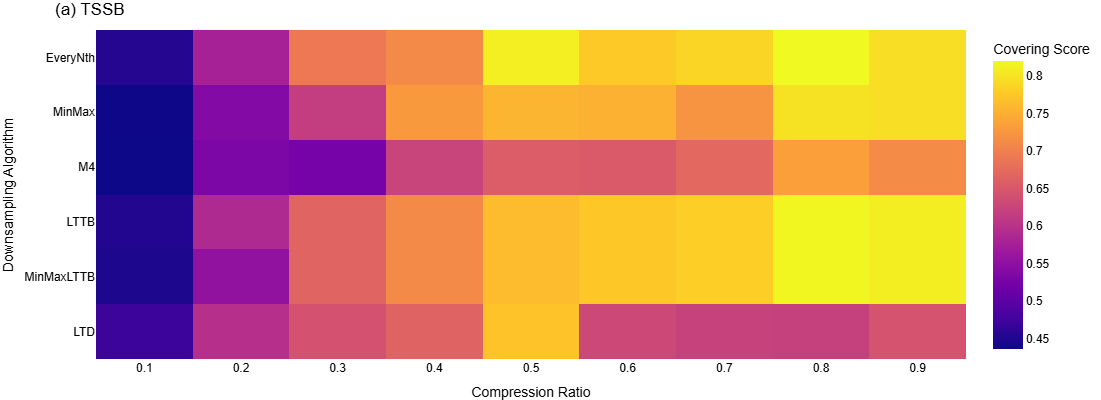

In [26]:
score_heatmap(tssb_res, "TSSB", title='(a) TSSB', filepath="results/figures/heatmap_meanScore_perAlgo_compRatio_TSSB.svg")

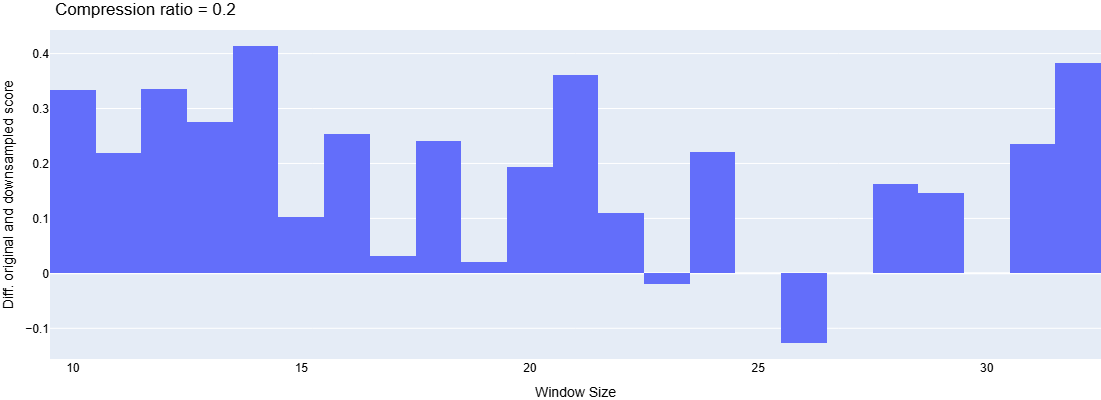

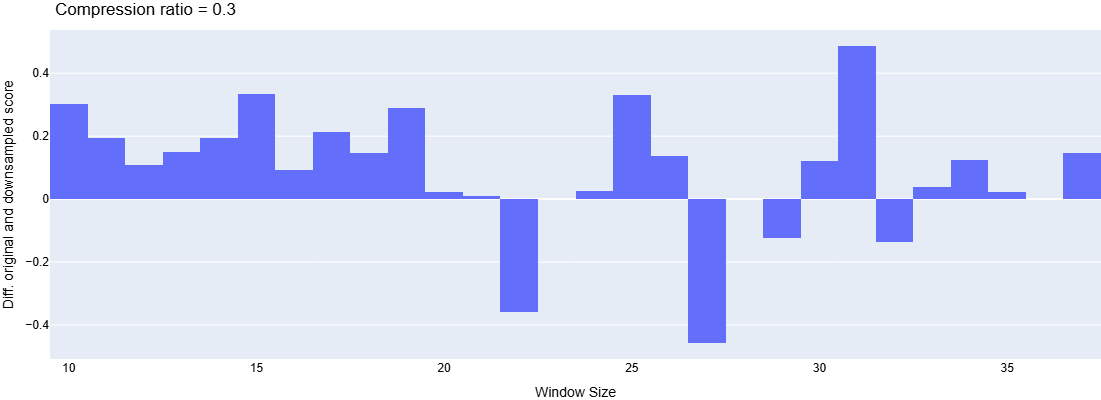

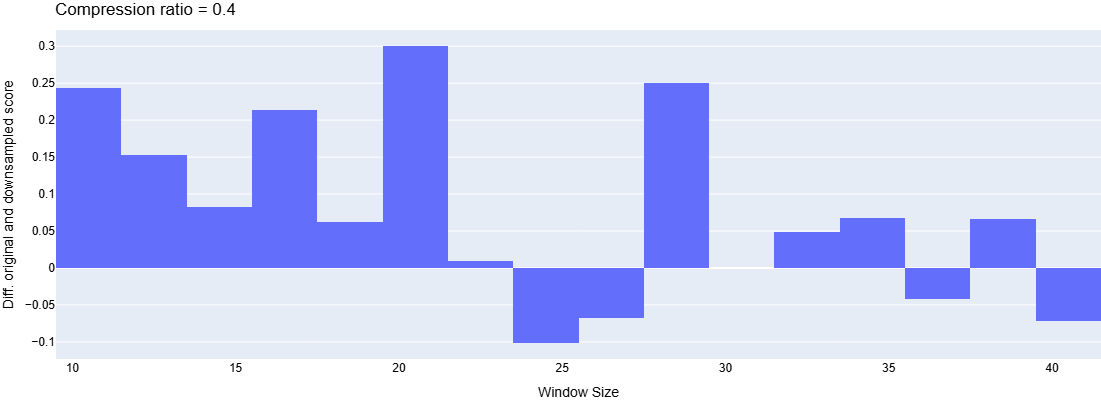

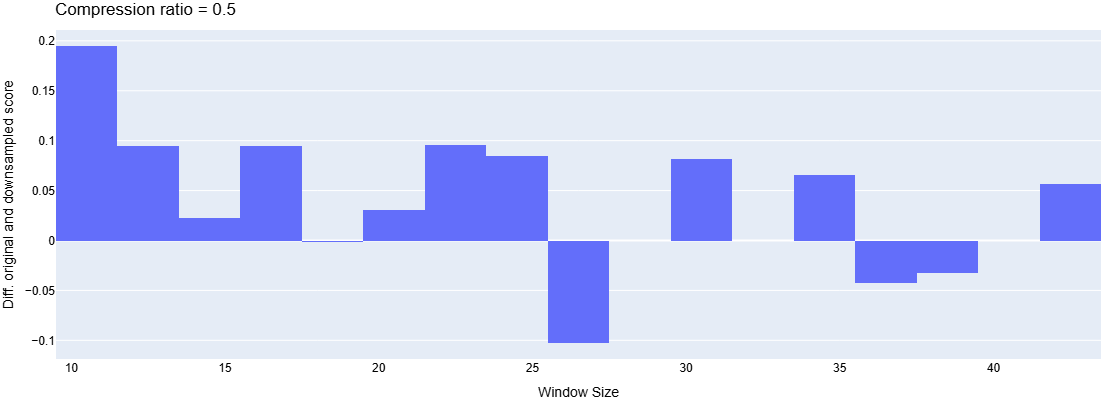

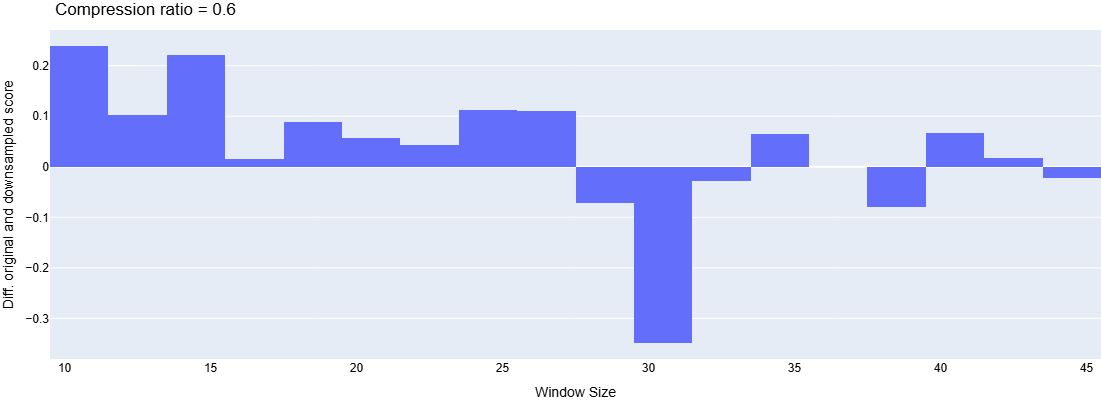

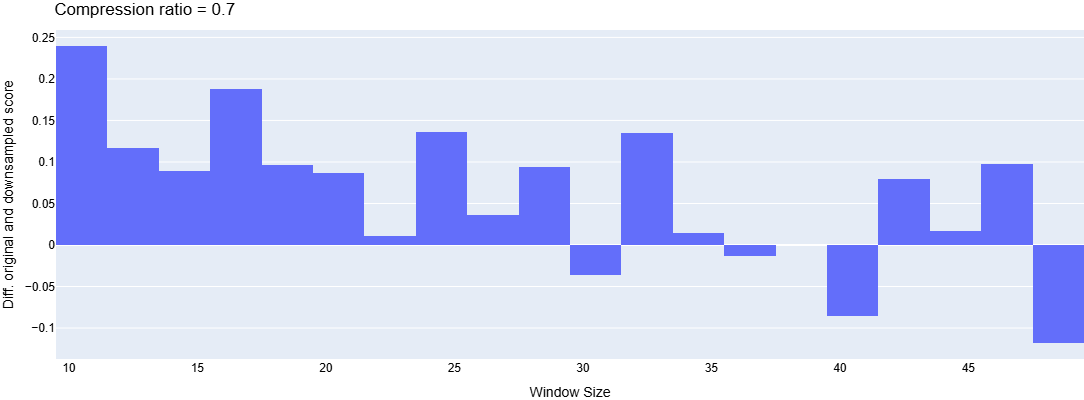

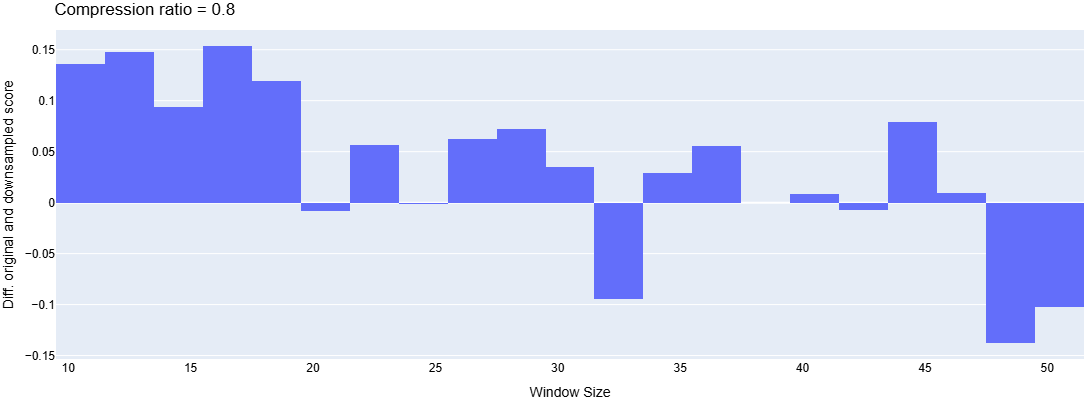

In [27]:
tssb_res['diff_scores'] = tssb_res.apply(add_score_diffs_tssb,axis=1)
crs_lim=np.round(np.arange(0.2,0.8,0.1),1)
for cr in crs_lim:
    plot_ws_differences(tssb_res, cr, filepath="results/figures/optimalCR/WS_scoreDependency_CR" + str(cr).replace('.','') + "_TSSB.svg")

In [50]:
w_thresholds_tssb = get_w_thresholds([20,36], 5, tssb, tssb_res, scale=0, save_path='results/tables/window_size_threshold_TSSB_perAlgo.xlsx')
w_thresholds_tssb

Processing rows: 100%|█████████████████████████████████████████████████████████████████| 75/75 [00:41<00:00,  1.81it/s]


,20,25,30,35
algo,,,,
EveryNth,0.756213,0.785658,0.775244,0.782073
LTD,0.644636,0.631447,0.630028,0.627498
LTTB,0.750341,0.756481,0.774953,0.777493
M4,0.661091,0.665408,0.661537,0.668219
MinMax,0.728532,0.722853,0.714517,0.721846
MinMaxLTTB,0.744476,0.756322,0.774953,0.777493
mean,0.714215,0.719695,0.721872,0.725770


In [35]:
w_thresholds_tssb_general=get_w_thresholds_general([20,36], 5, tssb, tssb_res, scale=0, save_path='results/tables/window_size_threshold_TSSB.xlsx')
w_thresholds_tssb_general

,20,25,30,35
mean,0.714215,0.719695,0.721872,0.725770
median,0.727473,0.743995,0.727473,0.768412
std,0.249039,0.244775,0.245421,0.244224


### HASC

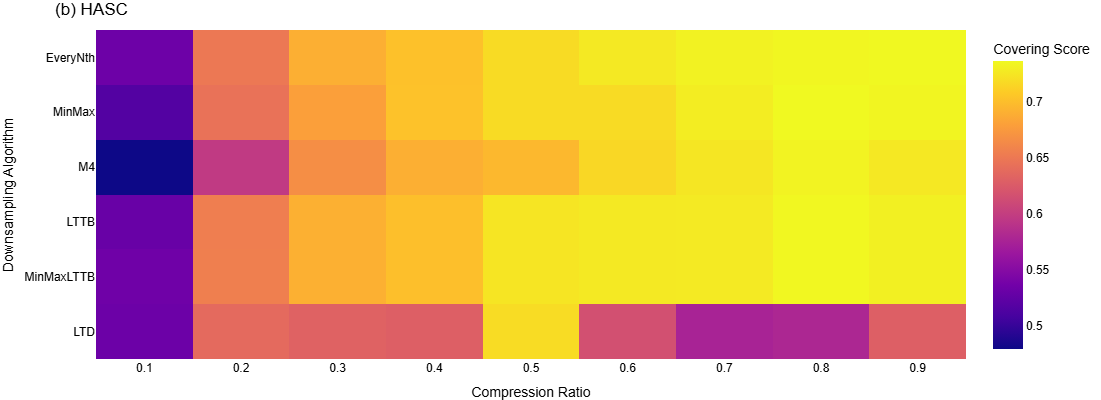

In [30]:
score_heatmap(hasc_res, "HASC", title='(b) HASC', filepath="results/figures/heatmap_meanScore_perAlgo_compRatio_HASC.svg")

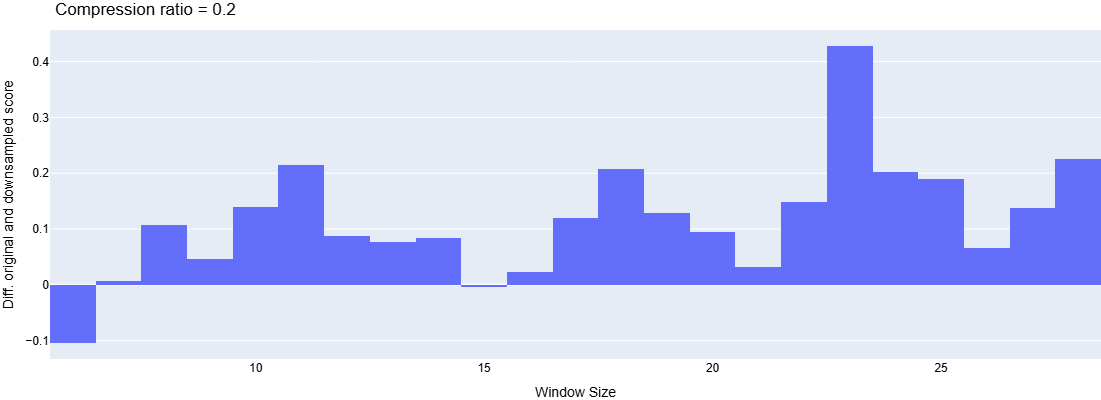

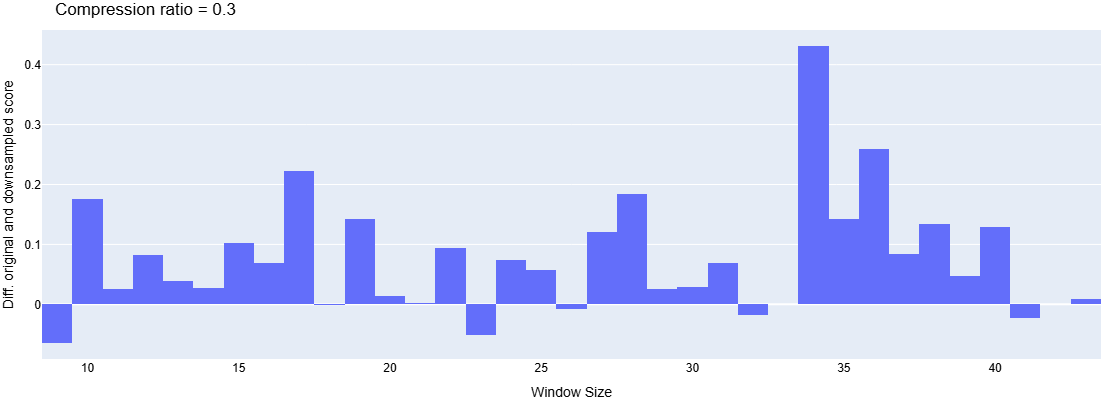

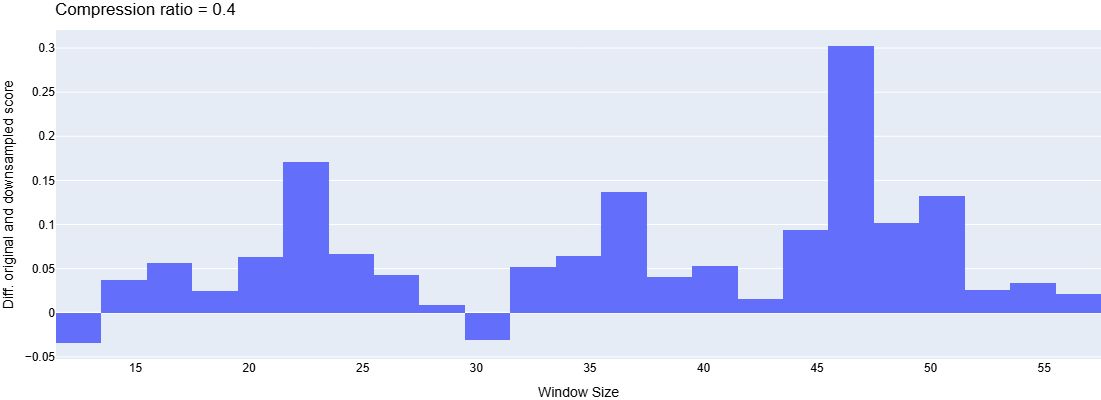

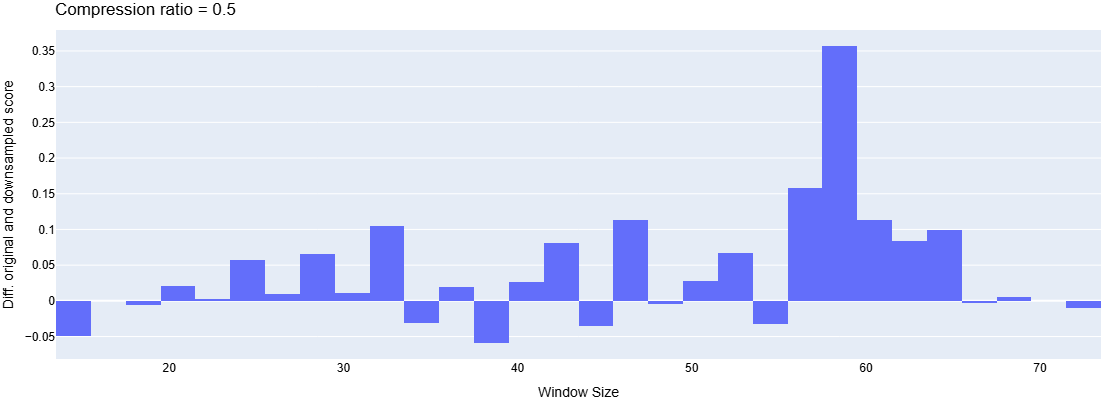

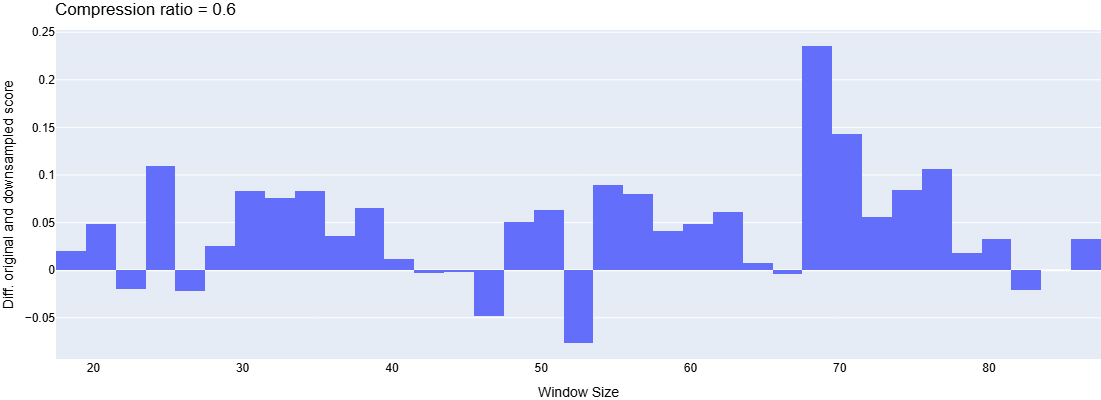

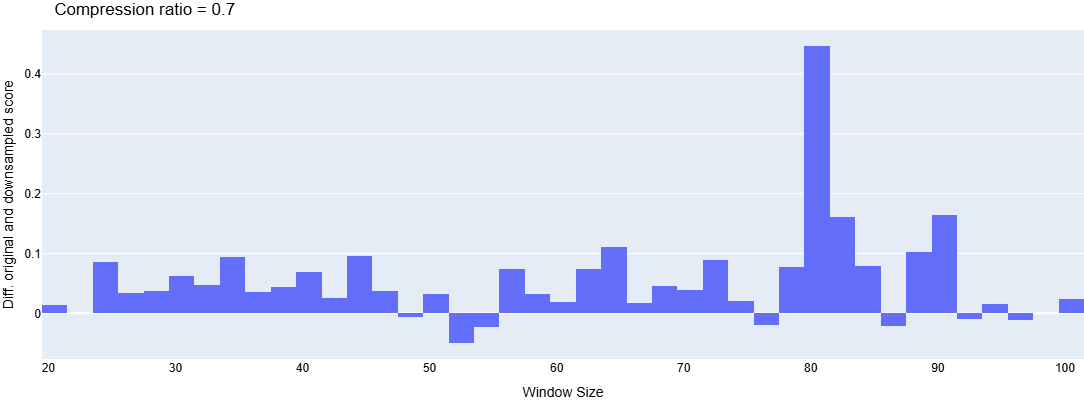

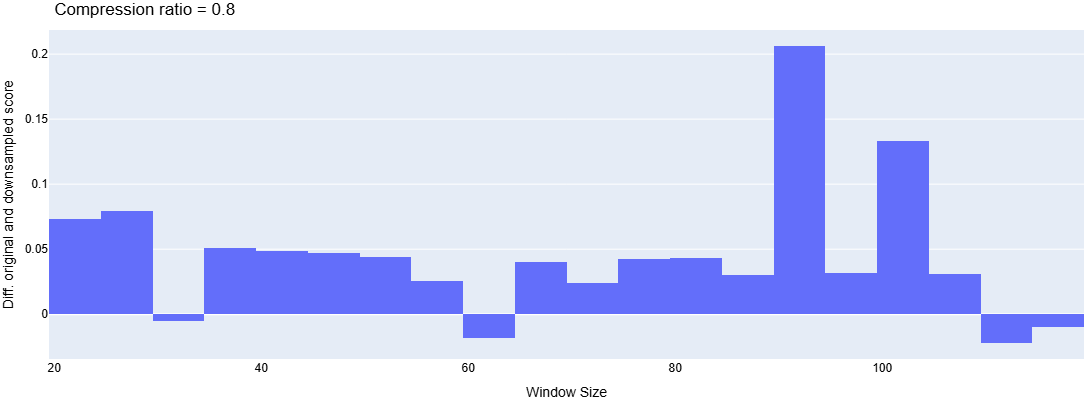

In [31]:
hasc_res['diff_scores'] = hasc_res.apply(add_score_diffs_hasc,axis=1)
crs_lim=np.round(np.arange(0.2,0.8,0.1),1)
for cr in crs_lim:
    plot_ws_differences(hasc_res, cr, filepath="results/figures/optimalCR/WS_scoreDependency_CR" + str(cr).replace('.','') + "_HASC.svg")

In [51]:
w_thresholds_hasc = get_w_thresholds([30,100], 10, hasc, hasc_res, scale=1, save_path='results/tables/window_size_threshold_HASC_perAlgo.xlsx', ubound=True)
w_thresholds_hasc

Processing rows: 100%|███████████████████████████████████████████████████████████████| 250/250 [02:19<00:00,  1.80it/s]


,30,40,50,60,70,80,90
algo,,,,,,,
EveryNth,0.706868,0.733180,0.732564,0.732564,0.732564,0.732564,0.732564
LTD,0.645063,0.590643,0.575746,0.575746,0.575746,0.575746,0.575746
LTTB,0.707965,0.725488,0.727787,0.727787,0.727787,0.727787,0.727787
M4,0.685200,0.713538,0.724913,0.724913,0.724913,0.724913,0.724913
MinMax,0.713553,0.722587,0.729441,0.729441,0.729441,0.729441,0.729441
MinMaxLTTB,0.707965,0.725488,0.727787,0.727787,0.727787,0.727787,0.727787
mean,0.694436,0.701821,0.703040,0.703040,0.703040,0.703040,0.703040


In [33]:
w_thresholds_hasc_general = get_w_thresholds_general([30,100], 10, hasc, hasc_res, scale=1, 
                                             save_path='results/tables/window_size_threshold_HASC.xlsx', ubound=True)
w_thresholds_hasc_general

,30,40,50,60,70,80,90
mean,0.694436,0.701821,0.703040,0.703040,0.703040,0.703040,0.703040
median,0.721121,0.713831,0.713705,0.713705,0.713705,0.713705,0.713705
std,0.233874,0.218935,0.215405,0.215405,0.215405,0.215405,0.215405


## Feature - based Compression Ratio

### TSSB

In [36]:
max_scores_tssb=max_scores_ts_algo(tssb_res)
max_scores_tssb

,index,algo,compression,window_size,orig_TS_ID,time_series,true_cps,ds_predictions,runtime,ucps,score,diff_scores
0,40,EveryNth,0.5,10,0,"[1.681146, 1.029389, 0.354835, -0.317504, -0.9...","[572, 1012, 1232]","[280, 504, 608]",0.062,"[560, 1008, 1216]",0.956048,-0.149048
1,47,LTD,0.3,10,0,"[1.681146, 1.383394, -0.935649, -1.420908, -1....","[572, 1012, 1232]","[143, 289]",0.078,"[476, 963]",0.693150,0.113850
2,31,LTTB,0.5,10,0,"[1.681146, 1.383394, 0.688386, -0.317504, -0.9...","[572, 1012, 1232]","[344, 504, 615]",0.094,"[688, 1008, 1230]",0.840687,-0.033687
3,21,M4,0.4,10,0,"[1.681146, 1.681146, -1.201327, -1.201327, -1....","[572, 1012, 1232]","[192, 374]",0.031,"[480, 935]",0.672924,0.134076
4,4,MinMax,0.5,10,0,"[1.681146, 0.688386, 0.354835, -0.638269, -0.9...","[572, 1012, 1232]","[289, 483]",0.188,"[578, 966]",0.805146,0.001854
...,...,...,...,...,...,...,...,...,...,...,...,...
445,4045,LTD,0.5,12,74,"[-0.155803, -0.564977, -0.665614, -0.467289, -...",[7295],[3641],7.484,[7282],0.998374,-0.246374
446,4027,LTTB,0.5,12,74,"[-0.155803, -0.564977, -0.665614, -0.467289, -...",[7295],[3641],7.875,[7282],0.998374,-0.246374
447,4020,M4,0.7,14,74,"[-0.155803, -0.155803, -0.667323, -0.573783, -...",[7295],[5176],11.828,[7394],0.987690,-0.235690
448,4000,MinMax,0.5,12,74,"[-0.155803, -0.667323, -0.665614, -0.376901, -...",[7295],[3656],7.656,[7312],0.997874,-0.245874


In [39]:
features_cr = create_feature_df(max_scores_tssb,tssb)
df_features_cr_tssb = pd.DataFrame(features_cr, columns=columns)
df_features_cr_tssb.to_pickle("results/zwischenergebnisse/cf_score_features_TSSB.pkl")
df_features_cr_tssb

,orig_TS_ID,algo,compression,score,statistical,temporal,spectral,MSE
0,0,EveryNth,0.5,0.956048,60.352123,141.233173,-2.369536e+03,2.571647e-08
1,0,LTD,0.3,0.693150,60.352123,141.233173,-2.369536e+03,2.571647e-08
2,0,LTTB,0.5,0.840687,60.352123,141.233173,-2.369536e+03,2.571647e-08
3,0,M4,0.4,0.672924,60.352123,141.233173,-2.369536e+03,2.571647e-08
4,0,MinMax,0.5,0.805146,60.352123,141.233173,-2.369536e+03,2.571647e-08
...,...,...,...,...,...,...,...,...
445,74,LTD,0.5,0.998374,605.898762,1653.639593,-3.842941e+06,4.487653e-11
446,74,LTTB,0.5,0.998374,605.898762,1653.639593,-3.842941e+06,4.487653e-11
447,74,M4,0.7,0.987690,605.898762,1653.639593,-3.842941e+06,4.487653e-11
448,74,MinMax,0.5,0.997874,605.898762,1653.639593,-3.842941e+06,4.487653e-11


In [40]:
corr_mat_tssb = create_corr_matrix_features(df_features_cr_tssb, save_path="results/tables/featureBasedCR_featureCorrelations_TSSB.xlsx")
corr_mat_tssb

,statistical,temporal,spectral,MSE
MinMax,-0.056386,-0.009316,-0.038112,-0.214078
MinMaxLTTB,0.109428,0.104010,0.035706,-0.224342
M4,0.170692,0.200646,-0.118144,-0.210979
LTTB,0.101255,0.105740,0.032996,-0.219443
EveryNth,0.207750,0.245175,-0.124498,-0.233418
LTD,-0.084617,-0.009894,0.020704,-0.205890


### HASC

In [41]:
max_scores_hasc=max_scores_ts_algo(hasc_res)
max_scores_hasc

,index,algo,compression,window_size,orig_TS_ID,time_series,true_cps,ds_predictions,runtime,ucps,score,diff_scores
0,44,EveryNth,0.9,61,0,"[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0...","[1461, 2952, 4473, 5022, 6460]","[870, 1310, 2676, 4008, 4446, 5811]",43.016,"[966, 1455, 2973, 4453, 4940, 6456]",0.904212,-0.491212
1,47,LTD,0.3,20,0,"[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0...","[1461, 2952, 4473, 5022, 6460]","[373, 722, 1242, 1891]",5.297,"[1243, 2406, 4140, 6303]",0.650180,-0.237180
2,30,LTTB,0.4,27,0,"[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0...","[1461, 2952, 4473, 5022, 6460]","[388, 2579]",12.422,"[970, 6447]",0.454973,-0.041973
3,24,M4,0.7,47,0,"[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0...","[1461, 2952, 4473, 5022, 6460]","[917, 2046, 2604, 2954, 3270, 3505, 4520]",28.594,"[1310, 2922, 3720, 4220, 4671, 5007, 6457]",0.830957,-0.417957
4,5,MinMax,0.6,40,0,"[[0.406, -0.4804, 1.775, -0.2425, 1.2022, -0.0...","[1461, 2952, 4473, 5022, 6460]","[648, 848, 1775, 2670, 2963, 3874]",22.969,"[1080, 1413, 2958, 4450, 4938, 6456]",0.916321,-0.503321
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,13492,LTD,0.2,6,249,"[[-4.083903, 1.3351410000000001, -9.1600174285...",[3533],[699],19.500,[3495],0.997556,-0.136556
1496,13475,LTTB,0.3,9,249,"[[-4.083903, 1.3351410000000001, -9.1600174285...",[3533],[1049],41.312,[3496],0.997621,-0.136621
1497,13467,M4,0.4,12,249,"[[-4.083903, 1.3351410000000001, -9.1600174285...",[3533],[1397],89.266,[3492],0.997364,-0.136364
1498,13447,MinMax,0.2,6,249,"[[-4.162383, 1.570581, -9.160017428571429, -1....",[3533],[699],18.516,[3495],0.997556,-0.136556


In [42]:
features_cr = create_feature_df(max_scores_hasc,hasc)
df_features_cr_hasc = pd.DataFrame(features_cr, columns=columns)
df_features_cr_hasc.to_pickle("results/zwischenergebnisse/cf_score_features_HASC.pkl")
df_features_cr_hasc

,orig_TS_ID,algo,compression,score,statistical,temporal,spectral,MSE
0,0,EveryNth,0.9,0.904212,289.234541,687.670827,-2.426101e+05,1.426645e-10
1,0,LTD,0.3,0.650180,289.234541,687.670827,-2.426101e+05,1.426645e-10
2,0,LTTB,0.4,0.454973,289.234541,687.670827,-2.426101e+05,1.426645e-10
3,0,M4,0.7,0.830957,289.234541,687.670827,-2.426101e+05,1.426645e-10
4,0,MinMax,0.6,0.916321,289.234541,687.670827,-2.426101e+05,1.426645e-10
...,...,...,...,...,...,...,...,...
1495,249,LTD,0.2,0.997556,1238.380758,2591.853582,-8.230961e+06,5.617531e-12
1496,249,LTTB,0.3,0.997621,1238.380758,2591.853582,-8.230961e+06,5.617531e-12
1497,249,M4,0.4,0.997364,1238.380758,2591.853582,-8.230961e+06,5.617531e-12
1498,249,MinMax,0.2,0.997556,1238.380758,2591.853582,-8.230961e+06,5.617531e-12


In [43]:
corr_mat_hasc = create_corr_matrix_features(df_features_cr_hasc, save_path="results/tables/featureBasedCR_featureCorrelations_HASC.xlsx")
corr_mat_hasc

,statistical,temporal,spectral,MSE
MinMax,0.058821,0.085278,0.072191,-0.221079
MinMaxLTTB,0.122660,0.137592,-0.008746,-0.212323
M4,0.169963,0.195344,-0.077459,-0.248394
LTTB,0.090744,0.105309,0.025182,-0.211524
EveryNth,0.051601,0.077324,0.064311,-0.213678
LTD,-0.044742,-0.025014,0.114394,-0.209128


## Result Summary

In [44]:
indicator_matrix=create_indicator_matrix(filename='feature_indicator_matrix')
indicator_matrix

,dataset,algorithm,best_indicator,correlation_coefficient,min_feature,max_feature
0,TSSB,MinMax,MSE,-0.214078,1.498864e-11,2.121889e-06
1,TSSB,MinMaxLTTB,MSE,-0.224342,1.498864e-11,2.121889e-06
2,TSSB,M4,MSE,-0.210979,1.498864e-11,2.121889e-06
3,TSSB,LTTB,MSE,-0.219443,1.498864e-11,2.121889e-06
4,TSSB,EveryNth,temporal,0.245175,2.705417e+01,2.573526e+03
5,TSSB,LTD,MSE,-0.205890,1.498864e-11,2.121889e-06
6,HASC,MinMax,MSE,-0.221079,2.180492e-12,2.858156e-07
7,HASC,MinMaxLTTB,MSE,-0.212323,2.180492e-12,2.858156e-07
8,HASC,M4,MSE,-0.248394,2.180492e-12,2.858156e-07
9,HASC,LTTB,MSE,-0.211524,2.180492e-12,2.858156e-07


### TSSB

In [52]:
best_thresholds_tssb = get_best_thresholds_per_algo(w_thresholds_tssb)
best_thresholds_tssb

Processing rows: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7013.89it/s]


{'EveryNth': 25,
 'LTD': 20,
 'LTTB': 35,
 'M4': 35,
 'MinMax': 20,
 'MinMaxLTTB': 35,
 'mean': 35}

In [53]:
tssb_cr_wBased_df, tssb_cr_wBased_algo_df = optimal_cr_w_based_summary(tssb,tssb_res,best_thresholds_tssb,scale=0)

Processing rows: 100%|█████████████████████████████████████████████████████████████████| 75/75 [01:21<00:00,  1.09s/it]


In [ ]:
tssb_cr_ftBased_df = optimal_cr_feature_based(tssb_res, 'TSSB', indicator_matrix)

In [55]:
score_matrix_tssb_crs = cr_score_matrix(tssb_res, tssb_cr_wBased_df, tssb_cr_wBased_algo_df, tssb_cr_ftBased_df, 0.5, 
                                        filepath="results/tables/compression_approaches_scores_TSSB.xlsx"
                                        )
score_matrix_tssb_crs.loc['mean'] = score_matrix_tssb_crs.mean()
score_matrix_tssb_crs

,score_all_cr,score_prev_best_cr,score_cr_wBased,score_cr_wBased_algo,score_cr_ftBased
algo,,,,,
EveryNth,0.713856,0.810907,0.816739,0.816739,0.589208
MinMax,0.682902,0.756242,0.798264,0.798264,0.572109
M4,0.616428,0.656903,0.729228,0.736013,0.534035
LTTB,0.707341,0.763613,0.815666,0.815666,0.610854
MinMaxLTTB,0.702853,0.763613,0.815666,0.815666,0.605092
LTD,0.629363,0.770931,0.627574,0.642701,0.579538
mean,0.675457,0.753702,0.767189,0.770841,0.581806


In [59]:
score_matrix_tssb_crs_noltd = score_matrix_tssb_crs.drop('LTD')
summaries=pd.DataFrame(columns=score_matrix_tssb_crs_noltd.columns.values)
summaries.loc['mean'] = score_matrix_tssb_crs_noltd.mean()
summaries.loc['median'] = score_matrix_tssb_crs_noltd.median()
summaries.loc['std'] = score_matrix_tssb_crs_noltd.std()
summaries.to_excel("results/tables/summmary_statistics_compression_approaches_scores_TSSB.xlsx")
summaries

,score_all_cr,score_prev_best_cr,score_cr_wBased,score_cr_wBased_algo,score_cr_ftBased
mean,0.683140,0.750830,0.790458,0.792198,0.582184
median,0.692878,0.759927,0.806965,0.806965,0.585507
std,0.035853,0.050588,0.035533,0.032721,0.027626


### HASC

In [58]:
best_thresholds_hasc = get_best_thresholds_per_algo(w_thresholds_hasc)
best_thresholds_hasc

Processing rows: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7017.24it/s]


{'EveryNth': 40,
 'LTD': 30,
 'LTTB': 50,
 'M4': 50,
 'MinMax': 50,
 'MinMaxLTTB': 50,
 'mean': 50}

In [ ]:
import warnings
warnings.filterwarnings('ignore')
hasc_cr_wBased_df,hasc_cr_wBased_algo_df = optimal_cr_w_based_summary(hasc,hasc_res,best_thresholds_hasc,scale=1,ubound=True)

In [ ]:
hasc_cr_ftBased_df = optimal_cr_feature_based(hasc_res, 'HASC', indicator_matrix)

In [57]:
score_matrix_hasc_crs = cr_score_matrix(hasc_res, hasc_cr_wBased_df, hasc_cr_wBased_algo_df, hasc_cr_ftBased_df, 0.5,
                                       filepath="results/tables/compression_approaches_scores_HASC.xlsx"
                                       )
score_matrix_hasc_crs.loc['mean'] = score_matrix_hasc_crs.mean()
score_matrix_hasc_crs

,score_all_cr,score_prev_best_cr,score_cr_wBased,score_cr_wBased_algo,score_cr_ftBased
algo,,,,,
EveryNth,0.691603,0.718504,0.730469,0.730469,0.623256
MinMax,0.686904,0.718570,0.724020,0.724020,0.620783
M4,0.670046,0.696130,0.720832,0.720832,0.596442
LTTB,0.691416,0.724298,0.728720,0.728720,0.623938
MinMaxLTTB,0.692014,0.724298,0.728720,0.728720,0.625337
LTD,0.616957,0.719262,0.577712,0.645063,0.567740
mean,0.674823,0.716844,0.701745,0.712971,0.609583


In [60]:
score_matrix_hasc_crs_noltd = score_matrix_hasc_crs.drop('LTD')
summaries=pd.DataFrame(columns=score_matrix_hasc_crs_noltd.columns.values)
summaries.loc['mean'] = score_matrix_hasc_crs_noltd.mean()
summaries.loc['median'] = score_matrix_hasc_crs_noltd.median()
summaries.loc['std'] = score_matrix_hasc_crs_noltd.std()
summaries.to_excel("results/tables/summmary_statistics_compression_approaches_scores_HASC.xlsx")
summaries

,score_all_cr,score_prev_best_cr,score_cr_wBased,score_cr_wBased_algo,score_cr_ftBased
mean,0.684468,0.716441,0.722418,0.724288,0.616556
median,0.689160,0.718537,0.726370,0.726370,0.622020
std,0.009624,0.010440,0.010739,0.006597,0.011380
